## Import

In [1]:
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils.data import TensorDataset, DataLoader
#from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))

Device: cuda


In [3]:
random_seed = 41

def seedEverything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)   


seedEverything(random_seed)

## Semi-Supervised Learning 

In [17]:
def evaluate(model, label_loader):
    
    total = 0
    correct = 0
    accuracy = 0
    test_loss = 0
    predicts = []
    targets = []
    decodeds = []
    ori = []
    
    model.eval()
    
    with torch.no_grad():
         for step, (x, y) in enumerate(label_loader):
                
            x = x.to(device).float()
            y = y.to(device)
           
            decoded = model(x)    

            loss = criterion(decoded, x)    # 재구성 오차 

            test_loss += loss.item()
            decodeds.extend(decoded)
            ori.extend(x)
            
            
            targets.extend(y.reshape(-1))

            
            del decoded, x, y
    

    
    return test_loss, ori, decodeds, targets 

In [19]:
# def score(y_true, y_pred):
    
#     true_positive  = 0 # TP 초기화
#     false_positive = 0 # FP 초기화
#     false_negative = 0 # FN 초기화 
#     true_negative  = 0 # TN 초기화 
    
    
#     for i in range(len(y_true)):
#         for j in range(len(y_true[i])):
            
#             if y_true[i][j] == 1:    # 실제 양성 
#                 if y_pred[i][j] == 1:
#                     true_positive+=1
#                 else:
#                     false_negative+=1
            
#             else:                   # 실제 음성
#                 if y_pred[i][j] == 1:
#                     false_positive+=1
#                 else:
#                     true_negative +=1
                    
                    
#     accuracy = (true_positive + true_negative)/(true_positive + false_positive + false_negative + true_negative)               
#     precision = true_positive / (true_positive + false_positive)     
#     recall = true_positive / (true_positive + false_negative)
#     f1_score = 2*precision*recall/(precision+recall)
     
#     accuracy = round(accuracy*100, 2)    
#     precision = round(precision*100, 2)
#     recall = round(recall*100, 2)
#     f1_score = round(f1_score*100, 2)
    
#     return accuracy, precision, recall, f1_score

In [19]:
# class EarlyStopping():
#     def __init__(self, patience=5, verbose=False, delta=0, path='./checkpoint.pt'):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None   # 검증 데이터셋에 대한 오차 최적화 값(오차가 가장 낮은 값)
#         self.early_stop = False  # 조기 종료를 의미하며 초깃값은 false로 설정 
#         self.delta = delta   
#         # delta : 오차가 개선되고 있다고 판단하기 위한 최소 변화량. 변화량이 delta보다 적다면 개선이 없다고 판단          
#         self.path = path   # 모델이 저장될 경로 
        
#     def __call__(self, val_loss, model):   
#         # 에포크만큼 학습이 반복되면서 best loss 가 갱신되고, best loss 에 진전이 없으면 조기 종료한 후 모델을 저장 
#         score = -val_loss

#         if self.best_score is None:  # best loss 존재하지 않으면 실행 
#             self.best_score = score
#             self.save_checkpoint(val_loss, model)
#         elif score < self.best_score + self.delta:  # best loss + 델타가 score보다 크면 실행 
#             self.counter += 1
#             print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:    # 그외 경우 실행 
#             self.best_score = score
#             self.save_checkpoint(val_loss, model)
#             self.counter = 0

#     def save_checkpoint(self, val_loss, model):   # 검증 데이터셋에 대한 오차가 감소하면 모델을 저장 
#         if self.verbose:
#             print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), self.path)
#         self.val_loss_min = val_loss

In [18]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
#             nn.Linear(30,256),
#             nn.BatchNorm1d(256),  
#             nn.LeakyReLU(),
            
            nn.Linear(30,128),
#             nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            
            nn.Linear(128,64),
#             nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            
            nn.Linear(64,28),
#             nn.BatchNorm1d(28),
            nn.LeakyReLU()
        )
        self.Decoder = nn.Sequential(
            nn.Linear(28,64),
#             nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            
            nn.Linear(64,128),
#             nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            
#             nn.Linear(128,256),
#             nn.BatchNorm1d(256),
#             nn.LeakyReLU(),
            
            nn.Linear(128,30)
        )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(30, 1),
#            # nn.Dropout(0.2),
#             nn.Sigmoid()
#         )
            
        
        
    def forward(self, x):
        x = self.Encoder(x)
        x1 = self.Decoder(x)
    
        return x1

In [19]:
def threshold(x_thr, model): 
    
    with torch.no_grad():  
        new = model(x_thr)
    
    mse = []
    for i in range(len(x_thr)):
        mse.append(criterion(x_thr[i], new[i]).item())
        
    
    thr = np.array(mse).mean()#+ np.array(mse).std()
    # thr = np.array(mse).max()
#     thr = np.median(mse)
    
    
    
    return thr

In [20]:
def hard_pseudo_label(ori, recon, threshold):  
    
    mse = []
    for i in range(len(ori)):
        mse.append(criterion(ori[i], recon[i]).item())
    
    pseudo_label = [1 if e > threshold else 0 for e in mse]   
    pseudo_label = torch.tensor(pseudo_label).to(device)
    pseudo_label = pseudo_label.reshape(-1,1)
        
    z = torch.cat([ori, recon, pseudo_label], dim=1) 
    z0 = z[z[:,-1] == 0]  

    ori0 = z0[:,:ori.shape[1]]
    recon0 = z0[:,ori.shape[1]:-1]
    y0 = z0[:,-1]
        
       
    return ori0, recon0, y0

In [21]:
num_epochs = 1000   
learning_rate = 0.001  
 
# early_stopping = EarlyStopping()

student = AutoEncoder().to(device)
teacher = AutoEncoder().to(device)

#------- get optimizers for student and teacher ------------------#
s_optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)  
t_optimizer = torch.optim.Adam(teacher.parameters(), lr=learning_rate)  

# s_scheduler = get_scheduler(s_optimizer, num_warmup_steps, num_steps)
# t_scheduler = get_scheduler(t_optimizer, num_warmup_steps, num_steps)
criterion = nn.MSELoss()

In [1]:
s_train_losses = []
t_train_losses = []

t_valid_losses0 = []
t_valid_losses = []
t_test_losses = []

s_valid_losses0 = []
s_valid_losses = []
s_test_losses = []

changes = []
num = []

label_valid_thr = label_valid_thr.to(device).float() 
start = time.time()


for epoch in range(num_epochs):   
    
    t_train_loss = 0.0 
    s_train_loss = 0.0 
    s_change = 0
    u_num = 0
    
    teacher.train()  
    student.train()
    
    total = 0
    correct = 0
    train_accuracy = 0
    
    
    for step, (label, unlabel) in enumerate(zip(label_train_loader0, unlabel_loader)):
     
        l_x = label[0].to(device).float()   #, dtype=torch.float)
        l_y = label[1].to(device)
        u_x = unlabel[0].to(device).float()
         
                
        t_optimizer.zero_grad()  
        s_optimizer.zero_grad()   
                
      
       ####################################################################### 
        
      
        s_l_logit_old = student(l_x)   
        
        
        s_l_loss_old = criterion(l_x, s_l_logit_old.detach())   
       
        del s_l_logit_old 
        
        
        # get teacher generated pseudo labels for unlabelled data
        
        t_u_logit = teacher(u_x) #.float()   
       
        thr = threshold(label_valid_thr, teacher)   
    
        t_ori_ux, t_recon_ux, t_uy = hard_pseudo_label(u_x, t_u_logit.detach(), thr) 
        
        del u_x, t_u_logit, thr
        
        t_u_loss = criterion(t_ori_ux, t_recon_ux) 
            
        del t_recon_ux
        
        #------ Train Student: With Pesudo Label Data ------------------#
   
            
        s_u_logit = student(t_ori_ux)
        
        s_u_loss = criterion(t_ori_ux, s_u_logit)
        
        del s_u_logit
        
        s_loss = s_u_loss
        
        s_train_loss += s_loss.item()
        
        s_loss.requires_grad_(True)
        s_loss.backward() 
        s_optimizer.step()   
        
        
    
        #------ Train Teacher ------------------------------------------#
        

        with torch.no_grad():  
            s_l_logit_new = student(l_x)
            
        s_l_loss_new = criterion(l_x, s_l_logit_new)
        
        del s_l_logit_new
        
        change = s_l_loss_new - s_l_loss_old  # performance improvement from student
                                                     
        t_l_logit = teacher(l_x) 
      
        t_l_loss = criterion(l_x, t_l_logit) 
        
        del l_x, t_l_logit
        
        t_mpl_loss = change * t_u_loss
        
        t_loss = t_l_loss + t_mpl_loss  
        


        t_train_loss += t_loss.item()
        t_loss.requires_grad_(True)
        t_loss.backward()
        t_optimizer.step()  
        torch.cuda.empty_cache()
                      
        s_change += change.item()
        
        if step == 0:
            u_num = t_ori_ux.shape[0]
    
    changes.append(s_change) 
    num.append(u_num)

    s_train_losses.append(s_train_loss) 
    t_train_losses.append(t_train_loss)        
    print("Epoch: %d, teacher loss: %1.5f, student loss: %1.5f" % (epoch+1, t_loss.item(), s_loss.item())) 

    
  
    ##################################################################################
    t_valid_loss0,_,_,_ = evaluate(teacher, label_valid_loader0)
    t_valid_loss,_,_,_ = evaluate(teacher, label_valid_loader)    
    t_test_loss,_,_,_ = evaluate(teacher, label_test_loader)
    
    s_valid_loss0,_,_,_ = evaluate(student, label_valid_loader0)
    s_valid_loss,_,_,_ = evaluate(student,label_valid_loader)     
    s_test_loss,_,_,_ = evaluate(student, label_test_loader)
    
    t_valid_losses0.append(t_valid_loss0) 
    t_valid_losses.append(t_valid_loss) 
    t_test_losses.append(t_test_loss) 
    
    s_valid_losses0.append(s_valid_loss0)
    s_valid_losses.append(s_valid_loss) 
    s_test_losses.append(s_test_loss) 
    
    
    print('nomal : ',u_num, 'change : ',change.item())

    print("Epoch: {}/{} ".format(epoch+1, num_epochs),
          "T_train Loss: {:.4f} ".format(t_train_loss),
          "T_valid Loss0: {:.4f} ".format(t_valid_loss0),
          "T_valid Loss: {:.4f} ".format(t_valid_loss),
          "T_Test Loss: {:.4f} ".format(t_test_loss))
    
    print("Epoch: {}/{} ".format(epoch+1, num_epochs),
          "S_train Loss: {:.4f} ".format(s_train_loss),
          "S_Valid Loss0: {:.4f} ".format(s_valid_loss0),
          "S_Valid Loss: {:.4f} ".format(s_valid_loss),
          "S_Test Loss: {:.4f} ".format(s_test_loss))
    print('\n')


    
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

In [23]:
# torch.save(teacher, 'model/teacher_pre0_15_e1000_mean_32.pt')
# torch.save(student, 'model/student_pre0_15_e1000_mean_32.pt')

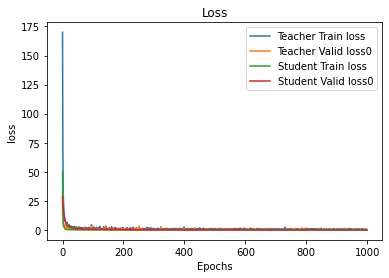

In [24]:
#fig = plt.figure(figsize=(12,5)) 
plt.plot(t_train_losses, label='Teacher Train loss')
plt.plot(t_valid_losses0, label='Teacher Valid loss0')

plt.plot(s_train_losses, label='Student Train loss')
plt.plot(s_valid_losses0, label='Student Valid loss0')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')    
plt.legend()

In [26]:
def mse_get(x, _x):
    mse = []
    for i in range(len(x)):
        mse.append(criterion(x[i], _x[i]).item())
    
    return mse

### student

In [41]:
_,valid_ori, valid_de, valid_y = evaluate(student,label_valid_loader)   
_,test_ori, test_de, test_y = evaluate(student, label_test_loader)   

s_valid_mse = mse_get(valid_ori, valid_de)
s_test_mse = mse_get(test_ori, test_de)

In [42]:
#valid
mse = pd.DataFrame({'Reconstruction_error':s_valid_mse})
true_valid = pd.DataFrame(torch.tensor(valid_y),columns = ['True_class'])
error_df = pd.concat([mse,true_valid] ,axis=1)
true_valid = pd.DataFrame(torch.tensor(valid_y),columns = ['True_class'])
error_df = pd.concat([mse,true_valid] ,axis=1)

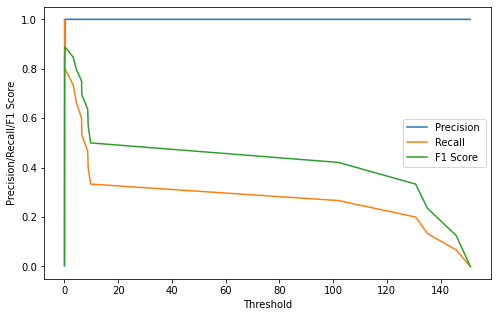

In [43]:
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])
F1  = (2* precision_rt[1:]* recall_rt[1:])/( precision_rt[1:] +recall_rt[1:])#F1 Score 

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.plot(threshold_rt, F1, label='F1 Score ')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall/F1 Score')
plt.legend()
plt.show()

In [44]:
m = pd.DataFrame({'F1' : F1, 'thr' :threshold_rt})    
thr = m['thr'][m['F1'] == m['F1'].max()].values
thr 

array([0.19068401])

In [45]:
z = [1 if e > thr else 0 for e in np.array(mse)]  
np.array(z).sum()

12

In [46]:
conf_matrix = metrics.confusion_matrix(z, torch.tensor(valid_y))   
print(conf_matrix)
print(metrics.classification_report(z, torch.tensor(valid_y)))

[[6141    3]
 [   0   12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6144
           1       0.80      1.00      0.89        12

    accuracy                           1.00      6156
   macro avg       0.90      1.00      0.94      6156
weighted avg       1.00      1.00      1.00      6156



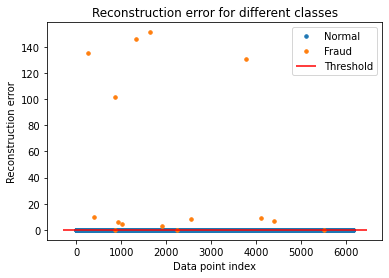

In [47]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(thr, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

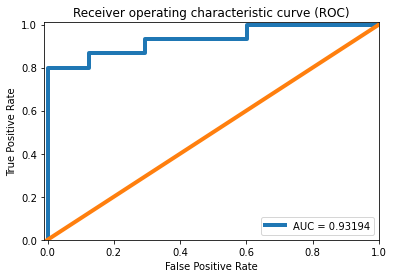

In [48]:
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(error_df['True_class'], error_df['Reconstruction_error'])
roc_auc = metrics.auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=4, label='AUC = %0.5f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=4)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.show()

In [49]:
# test
mse = pd.DataFrame({'Reconstruction_error':s_test_mse})
true_valid = pd.DataFrame(torch.tensor(test_y),columns = ['True_class'])
error_df = pd.concat([mse,true_valid] ,axis=1)
true_valid = pd.DataFrame(torch.tensor(test_y),columns = ['True_class'])
error_df = pd.concat([mse,true_valid] ,axis=1)

In [50]:
z = [1 if e > thr else 0 for e in np.array(mse)]  
np.array(z).sum()

14

In [51]:
conf_matrix = metrics.confusion_matrix(z, torch.tensor(test_y))  
print(conf_matrix)
print(metrics.classification_report(z, torch.tensor(test_y)))  

[[5117    2]
 [   1   13]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5119
           1       0.87      0.93      0.90        14

    accuracy                           1.00      5133
   macro avg       0.93      0.96      0.95      5133
weighted avg       1.00      1.00      1.00      5133



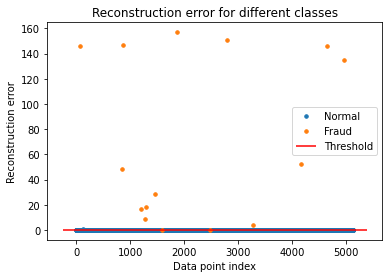

In [52]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(thr, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

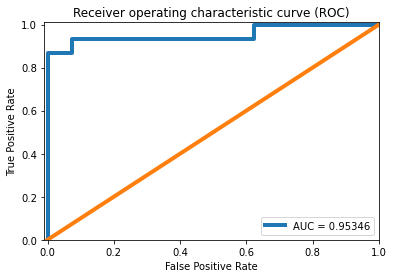

In [53]:
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(error_df['True_class'], error_df['Reconstruction_error'])
roc_auc = metrics.auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=4, label='AUC = %0.5f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=4)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.show()
